In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import random
import string
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, GRU

In [2]:
with open('/content/drive/MyDrive/tes/dataset_dl.json') as content:
  data = json.load(content)

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
#Mendapatkan semua data dalam list
tags = []
inputs = []
responses = {}
words = []
classes = []
documents = []
ignore_words = ['?', '!']

for intent in data['intens']:
  responses[intent['tag']] = intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))

      if intent['tag'] not in classes:
        classes.append(intent['tag'])

In [5]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, tags, test_size=0.2, random_state=20)
train_data = pd.DataFrame({"patterns": X_train, "tags": y_train})
test_data = pd.DataFrame({"patterns": X_test, "tags": y_test})

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  51 non-null     object
 1   tags      51 non-null     object
dtypes: object(2)
memory usage: 944.0+ bytes


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  13 non-null     object
 1   tags      13 non-null     object
dtypes: object(2)
memory usage: 336.0+ bytes


In [8]:
train_data.describe()

,patterns,tags
count,51,51
unique,51,16
top,Cuaca hari ini seperti apa?,cuaca
freq,1,4


In [9]:
test_data.describe()

,patterns,tags
count,13,13
unique,13,10
top,Apa itu Madilog?,tan_malaka_filosofi
freq,1,2


In [10]:
train_data.head()

,patterns,tags
0,Cuaca hari ini seperti apa?,cuaca
1,Selamat pagi,salam
2,Siapa namamu?,nama
3,Buku apa yang ditulis oleh Tan Malaka?,tan_malaka_karya
4,Apa gagasan revolusi menurut Tan Malaka?,tan_malaka_perjuangan


In [11]:
test_data.head()

,patterns,tags
0,Apa itu Madilog?,tan_malaka_karya
1,Apa filosofi hidup Tan Malaka?,tan_malaka_filosofi
2,Nama kamu siapa?,nama
3,Apa kabar?,salam
4,Thanks,terima_kasih


In [12]:
train_data['patterns'] = train_data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: ''.join(wrd))
test_data['patterns'] = test_data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: ''.join(wrd))

In [13]:
from operator import le
#inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  tokens = nltk.word_tokenize(text)
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  lemmatized_text = ' '.join(lemmatized_tokens)
  return lemmatized_text

train_data['patterns'] = train_data['patterns'].apply(lemmatize_text)
test_data['patterns'] = test_data['patterns'].apply(lemmatize_text)

In [14]:
#Tokenisasi Data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_data['patterns'])

X_train = tokenizer.texts_to_sequences(train_data['patterns'])
X_test = tokenizer.texts_to_sequences(test_data['patterns'])

In [15]:
#Apply Padding
max_sequence_length = max(len(seq) for seq in X_train + X_test)
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [16]:
#Kombinasi tag dari train_data dan test_data
all_tags = list(set(train_data['tags']) | set(test_data['tags']))

le = LabelEncoder()
le.fit(all_tags)

y_train = le.transform(train_data['tags'])
y_test = le.transform(test_data['tags'])

In [17]:
train_dataset = (X_train, y_train)
test_dataset = (X_test, y_test)

In [18]:
#Model
regularization = regularizers.l2(0.01)

#Dropout
dropout_rate = 0.5

#Input layer
input_layer = Input(shape=(max_sequence_length,))

#Embedding layer
embedding_size = 100
x = Embedding(len(tokenizer.word_index) + 1, embedding_size)(input_layer)

#LSTM layer
lstm_units = 32
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)

#Gru layer
gru_units = 64
x = Bidirectional(GRU(gru_units, return_sequences=True))(x)

#Flatten layer
x = Flatten()(x)

#Dense layer
dense_units = 50
x = Dense(dense_units, activation='relu', kernel_regularizer=regularization)(x)
x = Dropout(dropout_rate)(x)

#Output layer
num_classes = len(classes)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 7, 100)              │           8,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 7, 64)               │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 7, 128)              │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          44,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             816 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,034 (539.20 KB)

 Trainable params: 138,034 (539.20 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9):
      print("\nAkurasi telah mencapai 90%, stop training")

      self.model.stop_training = True

In [20]:
cb = myCallback()
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
#Train model
history = model.fit(train_dataset[0], train_dataset[1], batch_size=10, epochs=100, callbacks=[cb], validation_data=test_dataset)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.0407 - loss: 3.6762 - val_accuracy: 0.0769 - val_loss: 3.5364
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1316 - loss: 3.4958 - val_accuracy: 0.0769 - val_loss: 3.3892
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1474 - loss: 3.3351 - val_accuracy: 0.0769 - val_loss: 3.2684
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0493 - loss: 3.2325 - val_accuracy: 0.0769 - val_loss: 3.1632
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0529 - loss: 3.1364 - val_accuracy: 0.1538 - val_loss: 3.0748
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1496 - loss: 3.0431 - val_accuracy: 0.1538 - val_loss: 3.0067
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1066 - loss: 2.9724 - val_accuracy: 0.1538 - val_loss: 2.9579
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1247 - loss: 2.8876 - val_accuracy: 0.1538 - val_los

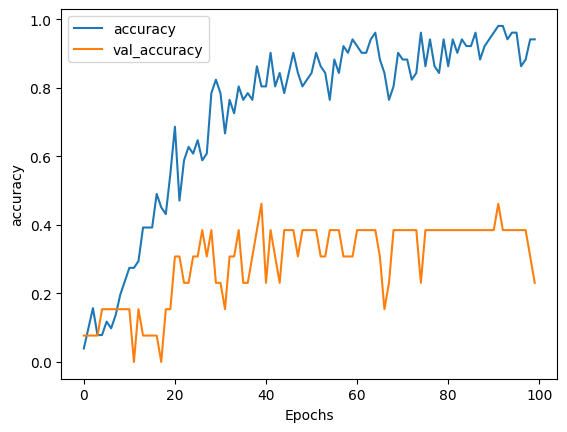

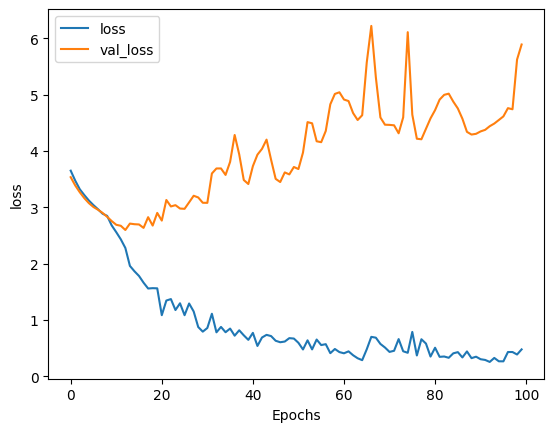

In [22]:
#Vis akurasi dan loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [31]:
#chat input
while True:
  texts = []
  prediction_input = input("Anda: ")

  #hapus punk dan lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts.append(prediction_input)

  #tokenisasi dan padding
  prediction_input = tokenizer.texts_to_sequences(texts)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input], maxlen=max_sequence_length)

  output = model.predict(prediction_input)
  output = output.argmax()

  response_tag = le.inverse_transform([output])[0]
  print("ChatBot: ", random.choice(responses[response_tag]))
  if response_tag == "perpisahan":
    break

Anda: halo siapa kamu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ChatBot:  Saya Chatbot generatif, senang berkenalan dengan Anda.
Anda: siapa sosok tan malaka?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ChatBot:  Tan Malaka adalah seorang pemimpin revolusioner dan intelektual asal Indonesia yang lahir pada 2 Juni 1897 di Nagari Pandan Gadang, Sumatera Barat.
Anda: apa karya tan malaka?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
ChatBot:  Ia dikenal sebagai tokoh yang memperjuangkan kemerdekaan Indonesia dengan gagasan revolusionernya.
Anda: madilog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
ChatBot:  Halo! Ada yang bisa saya bantu?
Anda: dadah
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
ChatBot:  Semoga harimu menyenangkan!
